In [1]:
import torch
data = torch.load('check/epoch624_batch119999_record_out_1')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


tensor([[1, 0, 1, 1, 6, 1, 1, 1],
        [2, 1, 4, 2, 1, 1, 1, 1],
        [3, 3, 1, 4, 2, 2, 2, 1],
        [1, 3, 3, 1, 1, 2, 4, 2]])
tensor([[0.5729, 0.9606, 0.7924, 0.8309, 0.1803, 0.9077, 0.6979, 0.9249],
        [0.4776, 0.6031, 0.1970, 0.3569, 0.5319, 0.6054, 0.5356, 0.6260],
        [0.2145, 0.2824, 0.4731, 0.2364, 0.3888, 0.3842, 0.3465, 0.4019],
        [0.3692, 0.2350, 0.2731, 0.6485, 0.4640, 0.3489, 0.2069, 0.3552]])
tensor([[ 1,  0, -1,  1,  1, -1, -1, -1],
        [-2, -1,  1, -2, -1,  1, -1, -1],
        [ 0,  0,  1,  0, -1,  1, -1, -1],
        [-1,  0,  0,  1,  1, -1,  0,  0]])
tensor([[0.3273, 0.9613, 0.5000, 0.4245, 0.1529, 0.4494, 0.3673, 0.6129],
        [0.3095, 0.3449, 0.1316, 0.2612, 0.3172, 0.3967, 0.3471, 0.4767],
        [0.2018, 0.1843, 0.3446, 0.1783, 0.3075, 0.2761, 0.2258, 0.3383],
        [0.2548, 0.2230, 0.2053, 0.3625, 0.3144, 0.2328, 0.1940, 0.2601]])
20203


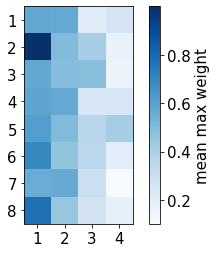

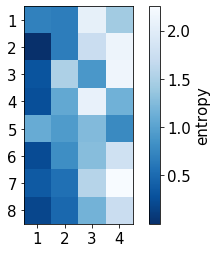

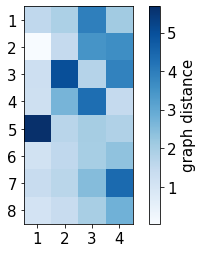

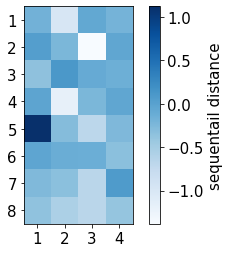

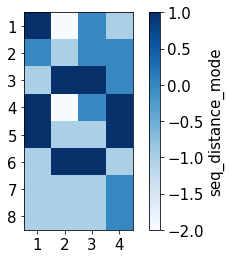

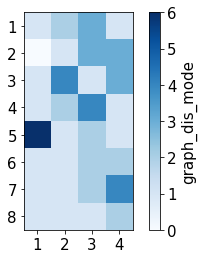

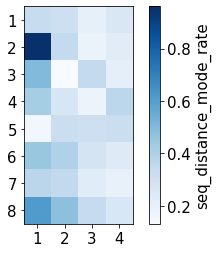

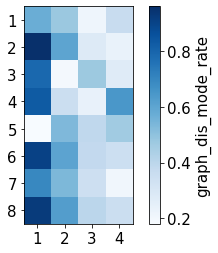

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

def draw_map(xticks, yticks, attns, label='', cmap='Blues'):
    plt.imshow(attns, interpolation='none', cmap=cmap)
    plt.xticks(np.array(range(len(yticks))), yticks);
    plt.yticks(np.array(range(len(xticks))), xticks);
    plt.colorbar(label=label)
    plt.xlim(left=-0.5, right=3.5)
    plt.ylim(top=-0.5, bottom=7.5)
    plt.show()

def analyse(x):
    """relative postion, syntactic/semantic path, rare heads"""
    ret = {}
    attn = x['attn'][:,1:,1:,:].permute(1, 0, 3, 2).contiguous()
    tgt_len, nlayers, nheads, src_len = attn.size()
    v_max, idx_max = torch.max(attn, -1)
    # nlayers x nheads
    ret['v_max_sum'] = v_max.sum(0)
    ret['len'] = len(x['concept'])
    entropy = torch.distributions.categorical.Categorical(attn).entropy().sum(0)
    ret['entropy'] = entropy
    graph_dis = []
    seq_dis = []
    for i, lyhd in enumerate(idx_max.tolist()):
        sdis = [[ x['depth'][j] -  x['depth'][i] for j in ly] for ly in lyhd ]
        gdis = [[x['relation'][str(i)][str(j)][0]['length'] for j in ly] for ly in lyhd ]
        graph_dis.append(torch.tensor(gdis))
        #print (torch.tensor(sdis))
        seq_dis.append(torch.tensor(sdis))
    ret['graph_dis'] = graph_dis
    ret['seq_dis'] = seq_dis
    return ret

v_max_avg = torch.zeros((4, 8))
entropy_avg = torch.zeros((4, 8))
graph_dis_all = []
seq_dis_all = []
tot = 0
for x in data:
    y = analyse(x)
    v_max_avg += y['v_max_sum']
    entropy_avg += y['entropy']
    graph_dis_all.extend(y['graph_dis'])
    seq_dis_all.extend(y['seq_dis'])
    tot += y['len']
v_max_avg = v_max_avg / tot
entropy_avg = entropy_avg / tot
graph_dis_all  = torch.stack(graph_dis_all, 0)
seq_dis_all = torch.stack(seq_dis_all, 0)
graph_dis_mode, _ = torch.mode(graph_dis_all.view(tot, -1), 0)
graph_dis_mode = graph_dis_mode.view(4, 8)
graph_dis_mode_rate = torch.eq(graph_dis_mode.unsqueeze(0), graph_dis_all).float().mean(0)
print (graph_dis_mode)
print (graph_dis_mode_rate)
seq_dis_mode, _ = torch.mode(seq_dis_all.view(tot, -1), 0)
seq_dis_mode = seq_dis_mode.view(4, 8)

seq_dis_mode_rate = torch.eq(seq_dis_mode.unsqueeze(0), seq_dis_all).float().mean(0)
print (seq_dis_mode)
print (seq_dis_mode_rate)

graph_dis_avg = torch.mean(graph_dis_all.float(), 0)
seq_dis_avg  =  torch.mean(seq_dis_all.float(), 0)
print (tot)
draw_map(['1', '2', '3', '4', '5','6','7','8'], ['1', '2', '3', '4'], v_max_avg.transpose(0, 1), 'mean max weight', 'Blues')
draw_map(['1', '2', '3', '4', '5','6','7','8'], ['1', '2', '3', '4'], entropy_avg.transpose(0, 1), 'entropy', 'Blues_r')
draw_map(['1', '2', '3', '4', '5','6','7','8'], ['1', '2', '3', '4'], graph_dis_avg.transpose(0, 1), 'graph distance', 'Blues')
draw_map(['1', '2', '3', '4', '5','6','7','8'], ['1', '2', '3', '4'], seq_dis_avg.transpose(0, 1), 'sequentail distance', 'Blues')

draw_map(['1', '2', '3', '4', '5','6','7','8'], ['1', '2', '3', '4'], seq_dis_mode.transpose(0, 1), 'seq_distance_mode', 'Blues')
draw_map(['1', '2', '3', '4', '5','6','7','8'], ['1', '2', '3', '4'], graph_dis_mode.transpose(0, 1), 'graph_dis_mode', 'Blues')
draw_map(['1', '2', '3', '4', '5','6','7','8'], ['1', '2', '3', '4'], seq_dis_mode_rate.transpose(0, 1), 'seq_distance_mode_rate', 'Blues')
draw_map(['1', '2', '3', '4', '5','6','7','8'], ['1', '2', '3', '4'], graph_dis_mode_rate.transpose(0, 1), 'graph_dis_mode_rate', 'Blues')




In [3]:
print (seq_dis_avg)

tensor([[-0.1782,  0.0379, -0.3472, -0.0224,  1.1230, -0.0364, -0.2640, -0.3559],
        [-0.9880, -0.2349,  0.1057, -1.1808, -0.2942, -0.1279, -0.3308, -0.5547],
        [-0.0662, -1.3823, -0.0906, -0.2276, -0.6845, -0.1359, -0.6601, -0.6654],
        [-0.1947, -0.0485, -0.1448, -0.0460, -0.2487, -0.3257,  0.0773, -0.3909]])


tensor([[False, False, False, False,  True, False, False, False],
        [False, False,  True,  True, False, False, False, False],
        [ True,  True, False,  True,  True, False,  True, False],
        [ True,  True,  True, False, False,  True,  True,  True]])
0.4375


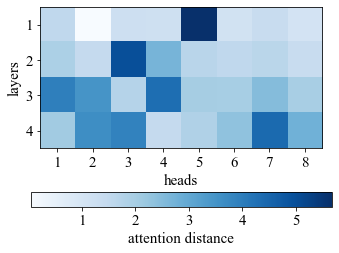

In [4]:
#%matplotlib inline
import matplotlib
matplotlib.font_manager._rebuild()
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

def draw_map(xticks, yticks, attns, label='', cmap='Blues'):
    plt.imshow(attns, interpolation='nearest', cmap=cmap)
    plt.xlabel('heads')
    plt.ylabel('layers')
    plt.xticks(np.array(range(len(yticks))), yticks);
    plt.yticks(np.array(range(len(xticks))), xticks);
    plt.colorbar(label=label,orientation='horizontal', pad=0.2, shrink=0.9)
    plt.xlim(left=-0.5, right=7.5)
    plt.ylim(top=-0.5, bottom=3.5)
    plt.savefig('./haha.pdf')
    #plt.show()
print (graph_dis_avg >= 2) 
print (14/ 32)

draw_map(['1', '2', '3', '4'], ['1', '2', '3', '4', '5','6','7','8'], graph_dis_avg, 'attention distance', 'Blues')